In [1]:
# import python pieces
import os
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp


In [2]:
from lsst.utils import getPackageDir

def loadStarDens(sfilt='r', nside=64, wdstars='', trilegal=False, dustonly=False):
    
    """Loads the stellar density maps. nside not equal to 64 will only work if those paths exist on the system.
    
    For star maps, use wdstars='_wdstars' to retrieve white dwarfs"""
    
    # trilegal is now sent in as a boolean (so that we can use the same boolean when calling other
    # routines to reorder trilegal if necessary)
    
    # 2021-03-25 (WIC) - I'm not clear whether Trilegal maps actually work the way I think they do - the 
    # mollview looks a little stripey. Perhaps Trilegal is nested and starmaps isn't, or vice versa?
    # To be revisited...
    
    # This at least supports getting the contents of star maps from different subdirectories.
    mapDir = getPackageDir('sims_maps')
    
    # We'll use glob to search for file paths matching the search string. This might be 
    # overkill (since at the moment the search strings ARE the paths we want) but it does
    # ensure we either get a readable path or no path.
    
    # search string for the map file. Default to starmaps.
    subdir='StarMaps'
    srchTail = 'starDensity_%s%s_nside_%i.npz' % (sfilt, wdstars, nside)
    
    if trilegal:
        subdir = 'TriMaps'
        srchTail = 'TRIstarDensity_%s_nside_%i.npz' % (sfilt, nside)
    
    if dustonly:
        subdir = 'DustMaps'
        srchTail = 'dust_nside_%i.npz' % (nside)
    
    # search for map file
    srchString = '%s/%s/%s' % (mapDir, subdir, srchTail)
    
    lPaths = glob.glob(srchString)
    if len(lPaths) < 1:
        print("loadStarDens WARN - no paths match string %s" % (srchString))
        return np.array([])
    
    print('getStarDens: loading path %s' % (lPaths[0]))
    starmap = np.load(lPaths[0])
    
    return starmap


In [3]:
def rotateHealpix(hpmap, transf=['C','G'], phideg=0., thetadeg=0.):
    
    """Rotates healpix map from one system to the other. Returns reordered healpy map. 
    Healpy coord transformations are used, or you can specify your own angles in degrees.
    To specify your own angles, ensure that transf has length != 2."""
    
    # For reasons I don't understand, entering in ['C', 'G'] seems to do the 
    # transformation FROM galactic TO equatorial. Possibly something buried in
    # the conventions used by healpy.
    
    # Heavily influenced by stack overflow solution here: 
    # https://stackoverflow.com/questions/24636372/apply-rotation-to-healpix-map-in-healpy
    
    nside = hp.npix2nside(len(hpmap))
    
    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))
    
    # Define a rotator
    if len(transf) == 2:
        r = hp.Rotator(coord=transf)
    else:
        r = hp.Rotator(deg=True, rot=[phideg,thetadeg])
    
    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)
    
    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hpmap, trot, prot)
    
    return rot_map


In [4]:
def getStarDens(starmap=None, maglim=24., isNested=False, isGalacs=False):
    
    """Given a star map and a limiting magnitude, returns the map value - all over the sky - at 
    that magnitude limit, as well as the magnitude limit actually used. (Currently does not 
    interpolate over magnitudes, but instead just uses the nearest bin.)"""
    
    # isNested = flag to trigger reordering from nested to ring
    
    if starmap is None:
        print("getStarDens WARN - starmap empty")
        return np.array([]), -99.
    
    # for the moment, just find the nearest bin upper edge to the bin, and select that plane of the map
    binFloors = starmap['bins']
    planeNearest = np.argmin(np.abs(binFloors-maglim))
    
    # the bin- and values-arrays are one off in size
    if planeNearest < 1:
        planeNearest = 1.
    
    magFloor = binFloors[planeNearest]
    hpvalues = starmap['starDensity'][:,planeNearest]
    
    # reorder to ring if given nested
    if isNested:
        values = np.copy(hpvalues)
        hpvalues = hp.reorder(values, n2r=True)
    
    # if given in galactic coords, use our rotator to interpolate to equatorial
    if isGalacs:
        hpvalues = rotateHealpix(hpvalues)
    
    # make hpvalues a masked array
    hpmasked = np.ma.masked_less_equal(hpvalues, 0.)
        
    return hpmasked, magFloor


In [24]:
ls "/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maps/2017.05.08-4-gac432e6/"

DustMaps/  README.md  StarMaps/  TriMaps/  notebooks/  tests/  ups/


In [19]:
ls "/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maps/2017.05.08-4-gac432e6/StarMaps/"

starDensity_g_nside_64.npz          starDensity_u_nside_64.npz
starDensity_g_wdstars_nside_64.npz  starDensity_u_wdstars_nside_64.npz
starDensity_i_nside_64.npz          starDensity_y_nside_64.npz
starDensity_i_wdstars_nside_64.npz  starDensity_y_wdstars_nside_64.npz
starDensity_r_nside_64.npz          starDensity_z_nside_64.npz
starDensity_r_wdstars_nside_64.npz  starDensity_z_wdstars_nside_64.npz


In [26]:
ls "/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maps/2017.05.08-4-gac432e6/TriMaps/"


TRIstarDensity_g_nside_128.npz  TRIstarDensity_u_nside_128.npz
TRIstarDensity_g_nside_64.npz   TRIstarDensity_u_nside_64.npz
TRIstarDensity_i_nside_128.npz  TRIstarDensity_y_nside_128.npz
TRIstarDensity_i_nside_64.npz   TRIstarDensity_y_nside_64.npz
TRIstarDensity_r_nside_128.npz  TRIstarDensity_z_nside_128.npz
TRIstarDensity_r_nside_64.npz   TRIstarDensity_z_nside_64.npz


In [31]:
ls "/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maps/2017.05.08-4-gac432e6/DustMaps/"

SFD_dust_4096_ngp.fits  dust_nside_16.npz   dust_nside_4.npz
SFD_dust_4096_sgp.fits  dust_nside_2.npz    dust_nside_512.npz
dust_nside_1024.npz     dust_nside_256.npz  dust_nside_64.npz
dust_nside_128.npz      dust_nside_32.npz   dust_nside_8.npz


In [40]:
# Get the stellar density. Keep the filter as a variable so we know later on what density we used.
filtDens = 'r'
magnDens = 25.
isTrilegal = False

starmap = loadStarDens(filtDens, trilegal=isTrilegal, nside=64) 
stardens, magdens = getStarDens(starmap, magnDens, isNested=isTrilegal, isGalacs=isTrilegal)


getStarDens: loading path /home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maps/2017.05.08-4-gac432e6/StarMaps/starDensity_r_nside_64.npz


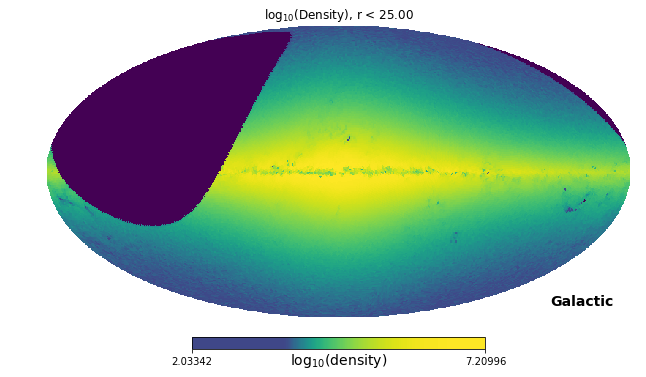

In [41]:
stardensShow = np.ma.copy(stardens)
stardensShow[stardensShow.mask] = np.ma.min(stardensShow)
hp.mollview(np.log10(stardensShow), unit=r'log$_{10}$(density)', title=r'log$_{10}$(Density), %s < %.2f' % (filtDens, magdens), 
           coord=['C','G'], norm='hist')
